In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
import os
import seaborn as sns
from scipy import stats
import sys
sys.path.append('..')
from madule import simulation
from madule import plots
from statsmodels.stats.anova import AnovaRM
from scipy.io import loadmat

In [6]:
# Read original action first amd color first task design to get reward schedule
dataActFirst = loadmat('/mnt/projects/7TPD/bids/derivatives/fMRI_DA/data_BehModel/predefined-task-values/ExpStruct_ActFirst_winOnly.mat')  
dataClrFirst = loadmat('/mnt/projects/7TPD/bids/derivatives/fMRI_DA/data_BehModel/predefined-task-values/ExpStruct_StimFirst_winOnly.mat')  

# read collected data across data
behAll = pd.read_csv('/mnt/projects/7TPD/bids/derivatives/fMRI_DA/data_BehModel/originalfMRIbehFiles/AllBehData/behAll.csv')
# rearrange trial number
behAll['trialNumber'].replace(
       [44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
        58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85],
       [2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
        30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43], inplace=True)

# Take a type of value learning and reversal envirnoment
block = 'Stim'
reverse =  14
behAllCond = behAll.loc[(behAll['block']==block)&(behAll['reverse']==reverse)]


In [7]:
# read collected data across data
behAll = pd.read_csv('/mnt/projects/7TPD/bids/derivatives/fMRI_DA/data_BehModel/originalfMRIbehFiles/AllBehData/behAll.csv')
# rearrange trial number
behAll['trialNumber'].replace(
       [44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
        58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85],
       [2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
        30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43], inplace=True)

# Take a type of value learning and reversal envirnoment
block = 'Stim'
reverse =  21
behAllCond = behAll.loc[(behAll['block']==block)&(behAll['reverse']==reverse)]

if block=='Stim' and reverse==21: 
    # Switch choice responses to proportional choices for Color value learning
    chosenOption = np.zeros(behAllCond.shape[0]) 
    chosenOption[behAllCond['stimActFirst']=='Stim'] = -(behAllCond.loc[behAllCond['stimActFirst']=='Stim']['yellowChosen']-1)
    chosenOption[behAllCond['stimActFirst']=='Act'] = behAllCond.loc[behAllCond['stimActFirst']=='Act']['yellowChosen']
    behAllCond['highRewardOption'] = chosenOption
    
elif block=='Act' and reverse==21: 
    # Switch choice responses to proportional choices for Action value learning
    chosenOption = np.zeros(behAllCond.shape[0]) 
    chosenOption[behAllCond['stimActFirst']=='Stim'] = -(behAllCond.loc[behAllCond['stimActFirst']=='Stim']['pushed']-1)
    chosenOption[behAllCond['stimActFirst']=='Act'] = behAllCond.loc[behAllCond['stimActFirst']=='Act']['pushed']
    behAllCond['highRewardOption'] = chosenOption

elif block=='Stim' and reverse==14:     
    # Switch choice responses to proportional choices for Color value learning
    chosenOption = np.zeros(behAllCond.shape[0]) 
    chosenOption[behAllCond['stimActFirst']=='Stim'] = -(behAllCond.loc[behAllCond['stimActFirst']=='Stim']['yellowChosen']-1)
    chosenOption[behAllCond['stimActFirst']=='Act'] = -(behAllCond.loc[behAllCond['stimActFirst']=='Act']['yellowChosen']-1)
    behAllCond['highRewardOption'] = chosenOption
    
elif block=='Act' and reverse==14: 
    # Switch choice responses to proportional choices for Color value learning
    chosenOption = np.zeros(behAllCond.shape[0]) 
    chosenOption[behAllCond['stimActFirst']=='Stim'] = behAllCond.loc[behAllCond['stimActFirst']=='Stim']['pushed']
    chosenOption[behAllCond['stimActFirst']=='Act'] = -(behAllCond.loc[behAllCond['stimActFirst']=='Act']['pushed']-1)
    behAllCond['highRewardOption'] = chosenOption


/tmp/ipykernel_3612370/3094510373.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behAllCond['highRewardOption'] = chosenOption


In [8]:
# Window size for moving average
window_size = 5

"""High reward option"""
# Average of chosen options Across participants for each trial
behAllCond_chosenOption = behAllCond.groupby(['group', 'trialNumber'], as_index=False)['highRewardOption'].mean()
 
# Assignment of x and y values from the mean across subject for each trial
y_1_chosenOption = behAllCond_chosenOption[behAllCond_chosenOption['group']==1]['highRewardOption']
windows_y_1_chosenOption = y_1_chosenOption.rolling(window=window_size, min_periods=1)
moving_averages_y_1_chosenOption = windows_y_1_chosenOption.mean()
  
y_2_chosenOption = behAllCond_chosenOption[behAllCond_chosenOption['group']==2]['highRewardOption']
windows_y_2_chosenOption = y_2_chosenOption.rolling(window=window_size, min_periods=1)
moving_averages_y_2_chosenOption = windows_y_2_chosenOption.mean()

y_3_chosenOption = behAllCond_chosenOption[behAllCond_chosenOption['group']==3]['highRewardOption']
windows_y_3_chosenOption = y_3_chosenOption.rolling(window=window_size, min_periods=1)
moving_averages_y_3_chosenOption = windows_y_3_chosenOption.mean()


"""Rewarded points"""
# Average of rewarded points Across participants for each trial
behAllCond_correctChoice = behAllCond.groupby(['group', 'trialNumber'], as_index=False)['correctChoice'].mean()
  
# Assignment of x and y values from the mean across subject for each trial
y_1_correctChoice = behAllCond_correctChoice[behAllCond_correctChoice['group']==1]['correctChoice']
windows_y_1_correctChoice = y_1_correctChoice.rolling(window=window_size, min_periods=1)
moving_averages_y_1_correctChoice = windows_y_1_correctChoice.mean()
  
y_2_correctChoice = behAllCond_correctChoice[behAllCond_correctChoice['group']==2]['correctChoice']
windows_y_2_correctChoice = y_2_correctChoice.rolling(window=window_size, min_periods=1)
moving_averages_y_2_correctChoice = windows_y_2_correctChoice.mean()

y_3_correctChoice = behAllCond_correctChoice[behAllCond_correctChoice['group']==3]['correctChoice']
windows_y_3_correctChoice = y_3_correctChoice.rolling(window=window_size, min_periods=1)
moving_averages_y_3_correctChoice = windows_y_3_correctChoice.mean()
 

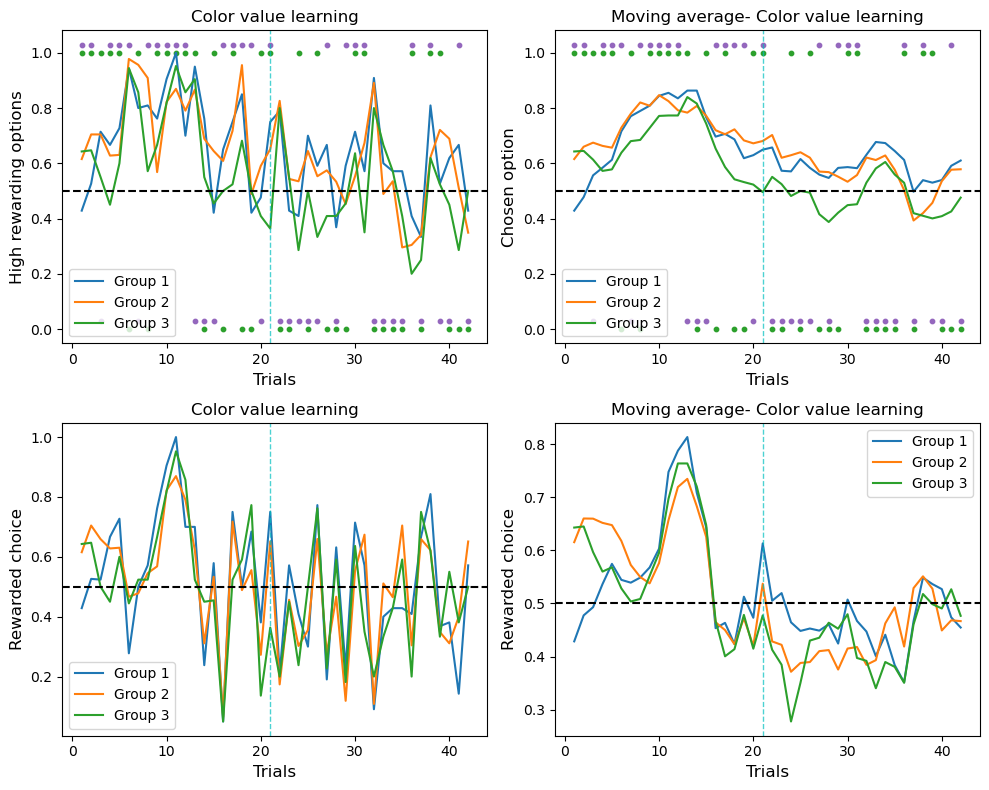

In [9]:
fig = plt.figure(figsize=(10,8), tight_layout=True)
row = 2
column = 2

"""Chosen option"""

# The original plot
fig.add_subplot(row, column, 1)
plt.plot(np.arange(1, 43), y_1_chosenOption)
plt.plot(np.arange(1, 43), y_2_chosenOption)
plt.plot(np.arange(1, 43), y_3_chosenOption)
plt.xlabel('Trials', fontsize='12')
plt.ylabel('High rewarding options', fontsize='12')
plt.legend(['Group 1', 'Group 2', 'Group 3'])
plt.axhline(y=.5, color='black' , linestyle='--')
# add title
if block=='Act':
    plt.title('Action value learning')
else:
    plt.title('Color value learning')
# add reversal vertical line
if reverse==21:
    plt.axvline(x = 21, color='c', linestyle='--', linewidth=1, alpha=.7)
else:
    plt.axvline(x = 14, color='c', linestyle='--', linewidth=1, alpha=.7)
    plt.axvline(x = 28, color='c', linestyle='--', linewidth=1, alpha=.7)
# add rewarding schedule points
if block=='Act' and reverse==21:
    plt.scatter(np.arange(1, 43), dataActFirst['triallist2_2'][0], s=10, c='#2ca02c', marker='o')
    plt.scatter(np.arange(1, 43), -(dataClrFirst['triallist1_2'][0]-1) + .03, s=10, c='#9467bd', marker='o')
elif block=='Stim' and reverse==21:
    plt.scatter(np.arange(1, 43), dataActFirst['triallist1_2'][0], s=10, c='#2ca02c', marker='o')
    plt.scatter(np.arange(1, 43), -(dataClrFirst['triallist1_1'][0]-1) + .03, s=10, c='#9467bd', marker='o')     
elif block=='Act' and reverse==14:
    plt.scatter(np.arange(1, 43), -(dataActFirst['triallist1_1'][0]-1), s=10, c='#2ca02c', marker='o')
    plt.scatter(np.arange(1, 43), dataClrFirst['triallist2_1'][0] + .03, s=10, c='#9467bd', marker='o')     
elif block=='Stim' and reverse==14:
    plt.scatter(np.arange(1, 43), -(dataActFirst['triallist2_1'][0]-1), s=10, c='#2ca02c', marker='o')
    plt.scatter(np.arange(1, 43), -(dataClrFirst['triallist2_2'][0]-1) + .03, s=10, c='#9467bd', marker='o')     

# The mosing average
fig.add_subplot(row, column, 2)
plt.plot(np.arange(1, 43), moving_averages_y_1_chosenOption)
plt.plot(np.arange(1, 43), moving_averages_y_2_chosenOption)
plt.plot(np.arange(1, 43), moving_averages_y_3_chosenOption)
plt.xlabel('Trials', fontsize='12')
plt.ylabel('Chosen option', fontsize='12')
plt.legend(['Group 1', 'Group 2', 'Group 3'])
plt.axhline(y=.5, color='black' , linestyle='--')
# Add titles
if block=='Act':
    plt.title('Moving average- Action value learning')
else:
    plt.title('Moving average- Color value learning')
# add reversla vertical line
if reverse==21:
    plt.axvline(x = 21, color='c', linestyle='--', linewidth=1, alpha=.7)
else:
    plt.axvline(x = 14, color='c', linestyle='--', linewidth=1, alpha=.7)
    plt.axvline(x = 28, color='c', linestyle='--', linewidth=1, alpha=.7)
# add rewarding schedule points
if block=='Act' and reverse==21:
    plt.scatter(np.arange(1, 43), dataActFirst['triallist2_2'][0], s=10, c='#2ca02c', marker='o')
    plt.scatter(np.arange(1, 43), -(dataClrFirst['triallist1_2'][0]-1) + .03, s=10, c='#9467bd', marker='o')
elif block=='Stim' and reverse==21:
    plt.scatter(np.arange(1, 43), dataActFirst['triallist1_2'][0], s=10, c='#2ca02c', marker='o')
    plt.scatter(np.arange(1, 43), -(dataClrFirst['triallist1_1'][0]-1) + .03, s=10, c='#9467bd', marker='o')     
elif block=='Act' and reverse==14:
    plt.scatter(np.arange(1, 43), -(dataActFirst['triallist1_1'][0]-1), s=10, c='#2ca02c', marker='o')
    plt.scatter(np.arange(1, 43), dataClrFirst['triallist2_1'][0] + .03, s=10, c='#9467bd', marker='o')     
elif block=='Stim' and reverse==14:
    plt.scatter(np.arange(1, 43), -(dataActFirst['triallist2_1'][0]-1), s=10, c='#2ca02c', marker='o')
    plt.scatter(np.arange(1, 43), -(dataClrFirst['triallist2_2'][0]-1) + .03, s=10, c='#9467bd', marker='o')     

    
"""Rewarded choice"""

# Original plot
fig.add_subplot(row, column, 3)
plt.plot(np.arange(1, 43), y_1_correctChoice)
plt.plot(np.arange(1, 43), y_2_correctChoice)
plt.plot(np.arange(1, 43), y_3_correctChoice)
plt.xlabel('Trials', fontsize='12')
plt.ylabel('Rewarded choice', fontsize='12')
plt.legend(['Group 1', 'Group 2', 'Group 3'])
plt.axhline(y=.5, color='black' , linestyle='--')
# add title
if block=='Act':
    plt.title('Action value learning')
else:
    plt.title('Color value learning')
# add reversal vertical line
if reverse==21:
    plt.axvline(x = 21, color='c', linestyle='--', linewidth=1, alpha=.7)
else:
    plt.axvline(x = 14, color='c', linestyle='--', linewidth=1, alpha=.7)
    plt.axvline(x = 28, color='c', linestyle='--', linewidth=1, alpha=.7)

# Moving average
fig.add_subplot(row, column, 4)
plt.plot(np.arange(1, 43), moving_averages_y_1_correctChoice)
plt.plot(np.arange(1, 43), moving_averages_y_2_correctChoice)
plt.plot(np.arange(1, 43), moving_averages_y_3_correctChoice)
plt.xlabel('Trials', fontsize='12')
plt.ylabel('Rewarded choice', fontsize='12')
plt.legend(['Group 1', 'Group 2', 'Group 3'])
plt.axhline(y=.5, color='black' , linestyle='--')
# Add titles
if block=='Act':
    plt.title('Moving average- Action value learning')
else:
    plt.title('Moving average- Color value learning')
# add reversla vertical line
if reverse==21:
    plt.axvline(x = 21, color='c', linestyle='--', linewidth=1, alpha=.7)
else:
    plt.axvline(x = 14, color='c', linestyle='--', linewidth=1, alpha=.7)
    plt.axvline(x = 28, color='c', linestyle='--', linewidth=1, alpha=.7)


# Save
#plt.savefig('../figures/Choice_proportion_group_effect_' +block+ '_'+ str(reverse)+'.png', dpi=300)


### Cumulative proportion

In [6]:
if block=='Stim' and reverse==21: 
    # Switch choice responses into correct choices for Color value learning
    highReward = np.zeros(behAllCond.shape[0]) 
    highReward[(behAllCond['stimActFirst']=='Stim')&(behAllCond['trialNumber']>=2)&(behAllCond['trialNumber']<=22)] = -(behAllCond.loc[(behAllCond['stimActFirst']=='Stim')&(behAllCond['trialNumber']>=2)&(behAllCond['trialNumber']<=22)]['yellowChosen']-1)
    highReward[(behAllCond['stimActFirst']=='Stim')&(behAllCond['trialNumber']>=23)&(behAllCond['trialNumber']<=43)] = behAllCond.loc[(behAllCond['stimActFirst']=='Stim')&(behAllCond['trialNumber']>=23)&(behAllCond['trialNumber']<=43)]['yellowChosen']
    highReward[(behAllCond['stimActFirst']=='Act')&(behAllCond['trialNumber']>=2)&(behAllCond['trialNumber']<=22)] = behAllCond.loc[(behAllCond['stimActFirst']=='Act')&(behAllCond['trialNumber']>=2)&(behAllCond['trialNumber']<=22)]['yellowChosen']
    highReward[(behAllCond['stimActFirst']=='Act')&(behAllCond['trialNumber']>=23)&(behAllCond['trialNumber']<=43)] = -(behAllCond.loc[(behAllCond['stimActFirst']=='Act')&(behAllCond['trialNumber']>=23)&(behAllCond['trialNumber']<=43)]['yellowChosen']-1)
    behAllCond['highReward'] = highReward
        
elif block=='Act' and reverse==21: 
    # Switch choice responses into correct choices for Color value learning
    highReward = np.zeros(behAllCond.shape[0]) 
    highReward[(behAllCond['stimActFirst']=='Stim')&(behAllCond['trialNumber']>=2)&(behAllCond['trialNumber']<=22)] = -(behAllCond.loc[(behAllCond['stimActFirst']=='Stim')&(behAllCond['trialNumber']>=2)&(behAllCond['trialNumber']<=22)]['pushed']-1)
    highReward[(behAllCond['stimActFirst']=='Stim')&(behAllCond['trialNumber']>=23)&(behAllCond['trialNumber']<=43)] = behAllCond.loc[(behAllCond['stimActFirst']=='Stim')&(behAllCond['trialNumber']>=23)&(behAllCond['trialNumber']<=43)]['pushed']
    highReward[(behAllCond['stimActFirst']=='Act')&(behAllCond['trialNumber']>=2)&(behAllCond['trialNumber']<=22)] = behAllCond.loc[(behAllCond['stimActFirst']=='Act')&(behAllCond['trialNumber']>=2)&(behAllCond['trialNumber']<=22)]['pushed']
    highReward[(behAllCond['stimActFirst']=='Act')&(behAllCond['trialNumber']>=23)&(behAllCond['trialNumber']<=43)] = -(behAllCond.loc[(behAllCond['stimActFirst']=='Act')&(behAllCond['trialNumber']>=23)&(behAllCond['trialNumber']<=43)]['pushed']-1)
    behAllCond['highReward'] = highReward

elif block=='Stim' and reverse==14: 
    # Switch choice responses into correct choices for Color value learning
    highReward = np.zeros(behAllCond.shape[0]) 
    highReward[(behAllCond['stimActFirst']=='Stim')&(behAllCond['trialNumber']>=2)&(behAllCond['trialNumber']<=16)] = -(behAllCond.loc[(behAllCond['stimActFirst']=='Stim')&(behAllCond['trialNumber']>=2)&(behAllCond['trialNumber']<=16)]['yellowChosen']-1)
    highReward[(behAllCond['stimActFirst']=='Stim')&(behAllCond['trialNumber']>=17)&(behAllCond['trialNumber']<=29)] = behAllCond.loc[(behAllCond['stimActFirst']=='Stim')&(behAllCond['trialNumber']>=17)&(behAllCond['trialNumber']<=29)]['yellowChosen']
    highReward[(behAllCond['stimActFirst']=='Stim')&(behAllCond['trialNumber']>=30)&(behAllCond['trialNumber']<=43)] = -(behAllCond.loc[(behAllCond['stimActFirst']=='Stim')&(behAllCond['trialNumber']>=30)&(behAllCond['trialNumber']<=43)]['yellowChosen']-1)
       
    highReward[(behAllCond['stimActFirst']=='Act')&(behAllCond['trialNumber']>=2)&(behAllCond['trialNumber']<=16)] = -(behAllCond.loc[(behAllCond['stimActFirst']=='Act')&(behAllCond['trialNumber']>=2)&(behAllCond['trialNumber']<=16)]['yellowChosen']-1)
    highReward[(behAllCond['stimActFirst']=='Act')&(behAllCond['trialNumber']>=17)&(behAllCond['trialNumber']<=29)] = behAllCond.loc[(behAllCond['stimActFirst']=='Act')&(behAllCond['trialNumber']>=17)&(behAllCond['trialNumber']<=29)]['yellowChosen']
    highReward[(behAllCond['stimActFirst']=='Act')&(behAllCond['trialNumber']>=30)&(behAllCond['trialNumber']<=43)] = -(behAllCond.loc[(behAllCond['stimActFirst']=='Act')&(behAllCond['trialNumber']>=30)&(behAllCond['trialNumber']<=43)]['yellowChosen']-1)   
    behAllCond['highReward'] = highReward
    
elif block=='Act' and reverse==14: 
    # Switch choice responses into correct choices for Color value learning
    highReward = np.zeros(behAllCond.shape[0]) 
    highReward[(behAllCond['stimActFirst']=='Stim')&(behAllCond['trialNumber']>=2)&(behAllCond['trialNumber']<=16)] = behAllCond.loc[(behAllCond['stimActFirst']=='Stim')&(behAllCond['trialNumber']>=2)&(behAllCond['trialNumber']<=16)]['pushed']
    highReward[(behAllCond['stimActFirst']=='Stim')&(behAllCond['trialNumber']>=17)&(behAllCond['trialNumber']<=29)] = -(behAllCond.loc[(behAllCond['stimActFirst']=='Stim')&(behAllCond['trialNumber']>=17)&(behAllCond['trialNumber']<=29)]['pushed']-1)
    highReward[(behAllCond['stimActFirst']=='Stim')&(behAllCond['trialNumber']>=30)&(behAllCond['trialNumber']<=43)] = behAllCond.loc[(behAllCond['stimActFirst']=='Stim')&(behAllCond['trialNumber']>=30)&(behAllCond['trialNumber']<=43)]['pushed']
       
    highReward[(behAllCond['stimActFirst']=='Act')&(behAllCond['trialNumber']>=2)&(behAllCond['trialNumber']<=16)] = -(behAllCond.loc[(behAllCond['stimActFirst']=='Act')&(behAllCond['trialNumber']>=2)&(behAllCond['trialNumber']<=16)]['pushed']-1)
    highReward[(behAllCond['stimActFirst']=='Act')&(behAllCond['trialNumber']>=17)&(behAllCond['trialNumber']<=29)] = behAllCond.loc[(behAllCond['stimActFirst']=='Act')&(behAllCond['trialNumber']>=17)&(behAllCond['trialNumber']<=29)]['pushed']
    highReward[(behAllCond['stimActFirst']=='Act')&(behAllCond['trialNumber']>=30)&(behAllCond['trialNumber']<=43)] = -(behAllCond.loc[(behAllCond['stimActFirst']=='Act')&(behAllCond['trialNumber']>=30)&(behAllCond['trialNumber']<=43)]['pushed']-1)   
    behAllCond['highReward'] = highReward
    

/tmp/ipykernel_3576891/1899813348.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behAllCond['highReward'] = highReward


In [7]:
"""Comulative proportion of rewarded point across trials"""
y_1_correctChoice_cum = []
for i in range(2, 44):
    y_1_correctChoice_cum.append(behAllCond[(behAllCond['group']==1) & (behAllCond['trialNumber']<=i)]['correctChoice'].mean())

y_2_correctChoice_cum = []
for i in range(2, 44):
    y_2_correctChoice_cum.append(behAllCond[(behAllCond['group']==2) & (behAllCond['trialNumber']<=i)]['correctChoice'].mean())

y_3_correctChoice_cum = []
for i in range(2, 44):
    y_3_correctChoice_cum.append(behAllCond[(behAllCond['group']==3) & (behAllCond['trialNumber']<=i)]['correctChoice'].mean())


In [8]:
"""Comulative proportion of hight reward point across trials"""
y_1_highReward_choice_cum = []
for i in range(2, 44):
    y_1_highReward_choice_cum.append(behAllCond[(behAllCond['group']==1) & (behAllCond['trialNumber']<=i)]['highRewardOption'].mean())

y_2_highReward_choice_cum = []
for i in range(2, 44):
    y_2_highReward_choice_cum.append(behAllCond[(behAllCond['group']==2) & (behAllCond['trialNumber']<=i)]['highRewardOption'].mean())

y_3_highReward_choice_cum = []
for i in range(2, 44):
    y_3_highReward_choice_cum.append(behAllCond[(behAllCond['group']==3) & (behAllCond['trialNumber']<=i)]['highRewardOption'].mean())


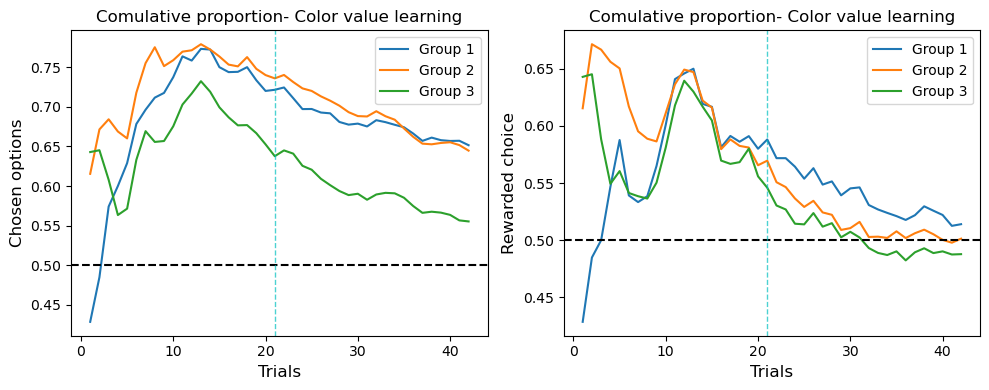

In [9]:
fig = plt.figure(figsize=(10,4), tight_layout=True)
row = 1
column = 2

"""Chosen option"""

# The original plot
fig.add_subplot(row, column, 1)
plt.plot(np.arange(1, len(y_1_highReward_choice_cum)+1), y_1_highReward_choice_cum)
plt.plot(np.arange(1, len(y_2_highReward_choice_cum)+1), y_2_highReward_choice_cum)
plt.plot(np.arange(1, len(y_3_highReward_choice_cum)+1), y_3_highReward_choice_cum)
plt.xlabel('Trials', fontsize='12')
plt.ylabel('Chosen options', fontsize='12')
plt.legend(['Group 1', 'Group 2', 'Group 3'])
plt.axhline(y=.5, color='black' , linestyle='--')
# add title
if block=='Act':
    plt.title('Comulative proportion- Action value learning')
else:
    plt.title('Comulative proportion- Color value learning')
# add reversal vertical line
if reverse==21:
    plt.axvline(x = 21, color='c', linestyle='--', linewidth=1, alpha=.7)
else:
    plt.axvline(x = 14, color='c', linestyle='--', linewidth=1, alpha=.7)
    plt.axvline(x = 28, color='c', linestyle='--', linewidth=1, alpha=.7)

"""Cumulative proportion Rewarded choice"""
# Original plot
fig.add_subplot(row, column, 2)
plt.plot(np.arange(1, len(y_1_correctChoice_cum)+1), y_1_correctChoice_cum)
plt.plot(np.arange(1, len(y_2_correctChoice_cum)+1), y_2_correctChoice_cum)
plt.plot(np.arange(1, len(y_3_correctChoice_cum)+1), y_3_correctChoice_cum)

plt.xlabel('Trials', fontsize='12')
plt.ylabel('Rewarded choice', fontsize='12')
plt.legend(['Group 1', 'Group 2', 'Group 3'])
plt.axhline(y=.5, color='black' , linestyle='--')
# add title
if block=='Act':
    plt.title('Comulative proportion- Action value learning')
else:
    plt.title('Comulative proportion- Color value learning')
# add reversal vertical line
if reverse==21:
    plt.axvline(x = 21, color='c', linestyle='--', linewidth=1, alpha=.7)
else:
    plt.axvline(x = 14, color='c', linestyle='--', linewidth=1, alpha=.7)
    plt.axvline(x = 28, color='c', linestyle='--', linewidth=1, alpha=.7)


# Save
plt.savefig('../figures/Cum_choice_proportion_group_effect_' +block+ '_'+ str(reverse)+'.png', dpi=300)

    